# Author: Sepehr SeifiZarei \\
# Date: 31/01/2023

# Initializing

## Installing Packages

In [1]:
!pip install mne
!pip install neurokit2
!pip install PyWavelets
!pip install tensorflow-addons
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.4 MB/s eta 0:00:00


## Mounting Google Drive

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Changing Current Directory to Dataset Folder Path
import os  
path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/'
os.chdir(path) 
print('[INFO] Current Directory is:', os.getcwd())

[INFO] Current Directory is: /content/drive/MyDrive/Work/UTU Work/TYKS_Phase1


## Functions

In [4]:
from src.functions.bcg_afib_detection import *
from src.functions.basics import *
from src.functions.bcg_processing import *
from src.functions.preprocessing import *
from src.functions.ecg_afib_detection import *

In [5]:
import pandas as pd
import numpy as np
import warnings
import os  
from matplotlib import pyplot as plt
import neurokit2 as nk
import pylab
import tensorflow as tf
import tensorflow_addons as tfa 
from keras.callbacks import ModelCheckpoint
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Importing Data

## Loading and extracting synced ECG and BCG signals

In [ ]:
#loading csv files
csv_paths, subjects_id = finding_files_path(path=path, suffix='csv', containing_word='merged', find_subject=True, verbose=True)

phase1_dict = dict()
last_point = 90
for count, j in enumerate(csv_paths[last_point:]):
    try:
        temp_dict = dict()
        print('subjects: ', subjects_id[count+last_point])
        df_iter = pd.read_csv(j, chunksize=5900, iterator=True)
        time_stamps = []
        ecg_sig = []
        bcg_sig_hi = []
        bcg_sig_low = []

        for iter_num, chunk in enumerate(df_iter, 1):
            if iter_num%500 == 0 :
                print(f'Processing iteration {iter_num}')
            #end if

            time_stamps.append(np.array(chunk['Unnamed: 0']))

            # ecg_sig.append(np.array(chunk['ECG'].interpolate(method='polynomial', order=3)))
            df = pd.DataFrame({'time_stamps': np.array(chunk['Unnamed: 0']), 'ECG': np.array(chunk['ECG'])})
            ecg_sig.append([np.array(df.dropna())])

            df = pd.DataFrame({'time_stamps': np.array(chunk['Unnamed: 0']), 'BCG_hi': np.array(chunk['rawdata_edf_bcg_hi_band'])})
            bcg_sig_hi.append([np.array(df.dropna())])

            df = pd.DataFrame({'time_stamps': np.array(chunk['Unnamed: 0']), 'BCG_low': np.array(chunk['rawdata_edf_bcg_lo_band'])})
            bcg_sig_low.append([np.array(df.dropna())])
        #end for
        print(f'Processing iteration {iter_num}')

        temp_dict[subjects_id[count+last_point]] = {'time_stamps': time_stamps, 'ECG': ecg_sig, 'BCG_hi': bcg_sig_hi, 'BCG_low': bcg_sig_low}
        phase1_clean_dict = clean_signal(temp_dict)
        print(phase1_clean_dict.keys())
        phase1_dict[subjects_id[count+last_point]] = phase1_clean_dict[list(phase1_clean_dict.keys())[0]]

        # Saveing Variables in a File
        import pickle

        # Saving the objects:
        save_name = 'phase1_dict_'+str(count+last_point)+'.pkl'
        with open(save_name, 'wb',) as f:  # Python 3: open(..., 'wb')
            pickle.dump([phase1_dict], f,) 
    except:
        print('something went wrong in subject',subjects_id[count+last_point])
#end for

# print(chunk.keys())

## Visualizing

In [ ]:
subject = subjects_id[1]
i=670
start_point = []
end_point = []


ecg = np.array(phase1_dict[subject]['ECG'][i][0])
bcg_hi = np.array(phase1_dict[subject]['BCG_hi'][i][0])
bcg_low = np.array(phase1_dict[subject]['BCG_low'][i][0])
print('ECG len:', len(ecg), 'BCH hi len:', len(bcg_hi), 'BCH low len:', len(bcg_low))
print('time range ', np.array(phase1_dict[subject]['time_stamps'][i][0]),'-',np.array(phase1_dict[subject]['time_stamps'][i][-1]))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(30, 16))
plt.title('Subject ' + subject + ': ')
plt.plot(ecg[:,0], ecg[:,1], label='ECG')
plt.plot(bcg_hi[:,0], bcg_hi[:,1]-400, label='BCG hi')
plt.plot(bcg_low[:,0], bcg_low[:,1]+400, label='BCG low')

sig = bcg_low
if len(sig)!=0:

    start_point = finding_start_points(sig[:,1])
    end_point = finding_end_points(sig[:,1])

    if len(start_point)!=0:
        for j in range(len(start_point)):
            plt.vlines(sig[start_point[j],0],-500,500, linestyles='dashed', colors='green', label='Start')
        #end for
    else:
        ecg_bcg_start_diff = ecg[0,0] - sig[0,0]
        # print(ecg_bcg_start_diff)
        if ecg_bcg_start_diff<-0.032:
            start_point.append(0)
            plt.vlines(sig[start_point[-1],0],-500,500, linestyles='dashed', colors='green', label='Start')
        elif np.std(sig[:,1])!=0:
            start_point.append(0)
            plt.vlines(sig[start_point[-1],0],-500,500, linestyles='dashed', colors='green', label='Start')
        #end if
    #end if

    if len(end_point)!=0:
        for j in range(len(end_point)):
            plt.vlines(sig[end_point[j],0],-500,500, linestyles='dashed', colors='red', label='End')
        #end for
    else:
        ecg_bcg_start_diff = ecg[-1,0] - sig[-1,0]
        # print(ecg_bcg_start_diff)
        if ecg_bcg_start_diff>0.032:
            end_point.append(-1)
            plt.vlines(sig[end_point[-1],0],-500,500, linestyles='dashed', colors='red', label='End')
        elif np.std(sig[:,1])!=0:
            end_point.append(-1)
            plt.vlines(sig[end_point[-1],0],-500,500, linestyles='dashed', colors='red', label='End')
        #end if
    #end if
#end if

pylab.gca().xaxis.set_major_formatter(pylab.mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()

print('start points: ', start_point)
print('end points: ', end_point)

## Merging all data together

In [ ]:
# Changing Current Directory to Dataset Folder Path

path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/'

saved_dataset_paths = finding_files_path(path=path, suffix='pkl', containing_word='dict', find_subject=False, verbose=True)

print(saved_dataset_paths)

In [ ]:
phase1_clean_dict = load_variables(saved_dataset_paths[0])
phase1_clean_dict = phase1_clean_dict[0]
print(phase1_clean_dict.keys())

bcg_len=[]
ecg_len=[]
for subject in phase1_clean_dict.keys():
    for i in range(len(phase1_clean_dict[subject]['ECG'])):
            print(len(phase1_clean_dict[subject]['BCG_low'][i]))
            print(len(phase1_clean_dict[subject]['ECG'][i]))
            bcg_len.append(len(phase1_clean_dict[subject]['BCG_low'][i]))
            ecg_len.append(len(phase1_clean_dict[subject]['ECG'][i]))
    #end for
#end for

ecg_len_thres = int(np.median(ecg_len))
bcg_len_thres = int(np.median(bcg_len))

print('ECG segment selected Length:', ecg_len_thres)
print('BCG segment selected Length:', bcg_len_thres)

In [ ]:
ecg_len_thres = 2457
bcg_len_thres = 3932

# select longer segments
bcg_low = []
bcg_hi = []
ecg = []
sub = []

bcg_low_test = []
bcg_hi_test = []
ecg_test = []
sub_test = []

test_subjects = ['1003', '1009', '1010', '1016', '1020', '1022', '1023', '1026', '1032', '1034', '1038', '1042', '1045', '1049', '1052','1056','1061', '1065', '1070', '1075', '1078', '1082', '1089', '1092', '1094'] # 8 AFIB and 17 SR

print(len(saved_dataset_paths),"Saved Dataset Paths:")
print(saved_dataset_paths)

for count, path in enumerate(saved_dataset_paths):
    print('[INFO] Loading path:', path)
    if count%2 == 0 and count!=0:
        # Saving extracted segments
        save_name = 'phase1_segments'+str(count)+'.pkl'
        save_variables([bcg_low, bcg_hi, ecg, sub], save_name)
        
        # Saving extracted Train_Validation segments
        save_name = 'phase1_test_segments.pkl'
        save_variables([bcg_low_test, bcg_hi_test, ecg_test, sub_test], save_name)

        bcg_low = []
        bcg_hi = []
        ecg = []
        sub = []
    #end if

    # Getting back the objects:
    phase1_clean_dict = load_variables(path)
    phase1_clean_dict = phase1_clean_dict[0]

    for subject in phase1_clean_dict.keys():
        for i in range(len(phase1_clean_dict[subject]['ECG'])):
            if subject in test_subjects:
                if len(phase1_clean_dict[subject]['ECG'][i])>=ecg_len_thres and len(phase1_clean_dict[subject]['BCG_low'][i])>=bcg_len_thres and len(phase1_clean_dict[subject]['BCG_hi'][i])>=bcg_len_thres:
                    bcg_low_test.append(phase1_clean_dict[subject]['BCG_low'][i][:bcg_len_thres])
                    bcg_hi_test.append(phase1_clean_dict[subject]['BCG_hi'][i][:bcg_len_thres])
                    ecg_test.append(phase1_clean_dict[subject]['ECG'][i][:ecg_len_thres])
                    sub_test.append(subject)
                #end if
            else:
                if len(phase1_clean_dict[subject]['ECG'][i])>=ecg_len_thres and len(phase1_clean_dict[subject]['BCG_low'][i])>=bcg_len_thres and len(phase1_clean_dict[subject]['BCG_hi'][i])>=bcg_len_thres:
                    bcg_low.append(phase1_clean_dict[subject]['BCG_low'][i][:bcg_len_thres])
                    bcg_hi.append(phase1_clean_dict[subject]['BCG_hi'][i][:bcg_len_thres])
                    ecg.append(phase1_clean_dict[subject]['ECG'][i][:ecg_len_thres])
                    sub.append(subject)
                #end if
            #end if
        #end for
    #end for
    print('[INFO] Total number of Train_Validation segments:', len(ecg))
#end for

# Saving extracted Train_Validation segments
save_name = 'phase1_segments'+str(count)+'.pkl'
save_variables([bcg_low, bcg_hi, ecg, sub], save_name)

# Saving extracted Train_Validation segments
save_name = 'phase1_test_segments.pkl'
save_variables([bcg_low_test, bcg_hi_test, ecg_test, sub_test], save_name)

print('[INFO] Total number of Test segments:', len(ecg_test))

# AFib Detection using ECG

## Loading Trained Model

In [ ]:
AFibModel = tf.keras.models.load_model(
    filepath='/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/AFib_model_227_0.9799_0.9688.h5'
    , custom_objects={'my_metric': my_metric}
)

## Evaluating

In [6]:
# Changing Current Directory to Dataset Folder Path
path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/'

saved_dataset_paths = finding_files_path(path=path, suffix='pkl', containing_word='dict', find_subject=False, verbose=True)

print(saved_dataset_paths)

[INFO] 10 pkl Paths
['/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_9.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_19.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_29.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_39.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_49.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_59.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_67.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_79.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_89.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/phase1_dict_93.pkl']


In [ ]:
output_dict = dict()

for path in saved_dataset_paths:
    print('[INFO] Loading path:', path)
    # Loading the file:
    phase1_clean_dict = load_variables(path)
    phase1_clean_dict = phase1_clean_dict[0]
    
    for subject in phase1_clean_dict.keys():
        SR_count = 0
        AFIB_count = 0
        fail_count = 0
        segment_number = []
        fail_segment_number = []
        output = []

        print('Subject',subject)
        ecg = phase1_clean_dict[subject]['ECG']
        print('Total number of segments is', len(ecg))
        for i in range(len(ecg)):
            if i%500==0:
                print('Processing segment',i)
            try:
                fs = len(ecg[i])/( np.array(ecg[i])[-1,0] - np.array(ecg[i])[0,0] )
                # print(fs)
                eee = np.array(ecg[i])[:,1]
                ecg_features = AFib_Model_Input_Features(eee, fs, plot=False)
                ecg_features = np.expand_dims(np.array(ecg_features),axis=1)
                yhat = AFibModel.predict(np.expand_dims(np.array(ecg_features),axis=0), verbose = 0)
                output.append(yhat)

                yhat[yhat>=0.5] = 1
                yhat[yhat<0.5] = 0

                if yhat==1:
                    AFIB_count += 1 

                elif yhat==0:
                    SR_count += 1
                #end if
                segment_number.append(i)

            except:
                fail_count += 1
                fail_segment_number.append(i)
                # print('something went wrong on epoch',i) #probably in HRV_calc function
        #end for
        print('SR segments count',SR_count)
        print('AFIB segments count',AFIB_count)
        print('Fail segments count',fail_count)
        print('Total segments count',SR_count+AFIB_count)
        output_dict[subject] = {'output': output, 'AFIB_count': AFIB_count, 'SR_count': SR_count, 'fail_count': fail_count, 'segment_number': segment_number ,'fail_segment_number': fail_segment_number}
    #end for
#end for

# Saving extracted segments
save_name = 'output_dict.pkl'
save_variables(output_dict, save_name)


In [ ]:
# testing different threshold values
threshold = 0.5

# Loading output_dict:
path = 'output_dict.pkl'
output_dict = load_variables(path)

for subject in output_dict.keys():
    SR_count = 0
    AFIB_count = 0

    print('Subject',subject)
    yhat = output_dict[subject]['output']
    # print(sum(yhat))
    for i in range(len(yhat)):
        # yhat[i] = yhat[i][0][0]
        
        if yhat[i]<=threshold:
            yhat[i] = 0
        elif yhat[i]>threshold:
            yhat[i] = 1
            # print('!!!!')

    # yhat[yhat>threshold] = 1
    # yhat[yhat<threshold] = 0

    afib_count = yhat.count(1)
    sr_count = yhat.count(0)

    if sr_count+afib_count != 0:
        print('SR segments count',sr_count ,'and', sr_count*100/(sr_count+afib_count), '% of all')
        print('AFIB segments count',afib_count ,'and', afib_count*100/(sr_count+afib_count), '% of all')
    print('Total segments count',sr_count+afib_count)
    print('Total fail segments count',output_dict[subject]['fail_count'])

    print(50*'*')
#end for


In [ ]:
# converting output dict to csv

# Loading output_dict:
path = 'output_dict.pkl'
output_dict = load_variables(path)

subs = []
sr_count = []
afib_count = []
segment_number = []
fail_count = []

for subject in output_dict.keys():
    subs.append(subject)
    sr_count.append(output_dict[subject]['SR_count'])
    afib_count.append(output_dict[subject]['AFIB_count'])
    fail_count.append(output_dict[subject]['fail_count'])
    segment_number.append(sr_count[-1]+afib_count[-1]+fail_count[-1])
#end for

mydict = {'Subjects': subs, 'AFIB_count': afib_count, 'SR_count': sr_count, 'fail_count': fail_count}

my_df = pd.DataFrame.from_dict(mydict, orient='index')
my_df.to_csv('output.csv')  

## Predicting

In [ ]:
# testing AFib Model

i = 6578
fs = len(ecg[i])/( np.array(ecg[i])[-1,0] - np.array(ecg[i])[0,0] )
print('Sampling Frequency is',fs)
eee = np.array(ecg[i])[:,1]
# eee = np.expand_dims(ecg,axis=1)
ecg_features = AFib_Model_Input_Features(eee, fs, plot=True)
ecg_features = np.expand_dims(np.array(ecg_features),axis=1)
print(ecg_features.shape)

yhat = AFibModel.predict(np.expand_dims(np.array(ecg_features),axis=0))
yhat[yhat>=0.5] = 1
yhat[yhat<0.5] = 0

if yhat==1:
  print('AFIB!')
else:
  print('SR')
#end

plt.plot(np.array(ecg[i])[:,1])
confusion_matrix = metrics.confusion_matrix(ecg_features, yhat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['SR', 'AFIB'])
cm_display.plot()
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/'

saved_dataset_paths = finding_files_path(path=path, suffix='pkl', containing_word='segments', find_subject=False, verbose=True)

print(saved_dataset_paths)

x_bcg_low = []
x_bcg_hi = []
x_sub = []
afib = []
x_ecg = []

for count, path in enumerate(saved_dataset_paths):
    print('[INFO] Loading path:', path)

    x_bcg_low = []
    x_bcg_hi = []
    x_sub = []
    afib = []
    x_ecg = []

    # Getting back the objects:
    bcg_low, bcg_hi, ecg, sub = load_variables(path)

    for i in range(len(ecg)):
        if i%5000 == 0:
            print('Epoch',i)
        #end if

        try:
            fs = len(ecg[i])/( np.array(ecg[i])[-1,0] - np.array(ecg[i])[0,0] )
            # print(fs)
            eee = np.array(ecg[i])[:,1]
            ecg_features = AFib_Model_Input_Features(eee, fs, plot=False)
            ecg_features = np.expand_dims(np.array(ecg_features),axis=1)
            yhat = AFibModel.predict(np.expand_dims(np.array(ecg_features),axis=0), verbose = 0)
            yhat[yhat>=0.5] = 1
            yhat[yhat<0.5] = 0

            x_bcg_low.append(bcg_low[i])
            x_bcg_hi.append(bcg_hi[i])
            x_ecg.append(ecg[i])
            x_sub.append(sub[i])

            if yhat==1:
                afib.append(1)
            else:
                afib.append(0)
            #end if
        except:
            pass
            # print('something went wrong on epoch',i) #probably in HRV_calc function
    #end for

    # Saving extracted segments
    if 'test' in path:
        save_name = 'bcg_afib_test_dataset.pkl'
        save_variables([x_bcg_low, x_bcg_hi, x_ecg, afib, x_sub], save_name)

    else:
        save_name = 'bcg_afib_train_dataset'+str(count)+'.pkl'
        save_variables([x_bcg_low, x_bcg_hi, x_ecg, afib, x_sub], save_name)
    #end if

    print('normal')
    print(afib.count(0))

    print('AFib')
    print(afib.count(1))
#end for


# Preprocessing

## Balancing

In [8]:
path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/'

saved_dataset_paths = finding_files_path(path=path, suffix='pkl', containing_word='afib', find_subject=False, verbose=True)

print(saved_dataset_paths)

[INFO] 6 pkl Paths
['/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_train_dataset0.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_train_dataset1.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_train_dataset2.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_train_dataset3.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_train_dataset4.pkl', '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/Saved Loaded Dataset/bcg_afib_test_dataset.pkl']


In [ ]:
# Balancing Train Dataset
x_bcg_low = []
x_bcg_hi = []
afib = []
x_ecg = []
x_sub = []

for count, path in enumerate(saved_dataset_paths):
    if 'train' in path:
        print('[INFO] Loading path:', path)

        # Getting back the objects:
        bcg_low, bcg_hi, ecg, afib_label, sub = load_variables(path)

        afib_count = 0

        for i in range(len(bcg_low)):
            if i%5000 == 0:
                print('Epoch',i)
            #end if

            if afib_label[i] == 1:
                afib.append(afib_label[i])
                x_bcg_low.append(bcg_low[i])
                x_bcg_hi.append(bcg_hi[i])
                x_ecg.append(ecg[i])
                x_sub.append(sub[i])
                afib_count += 1
                
            #end if
        #end for

        normal_count = 0
        sub_count = 0
        current_sub = '0'

        for i in range(len(bcg_low)):
            if afib_label[i] == 0 and normal_count < afib_count:
                
                if sub[i] != current_sub:
                    sub_count = 0  

                current_sub = sub[i]

                if sub_count < afib_count/len(set(sub)):
                    afib.append(afib_label[i])
                    x_bcg_low.append(bcg_low[i])
                    x_bcg_hi.append(bcg_hi[i])
                    x_ecg.append(ecg[i])
                    x_sub.append(sub[i])
                    normal_count += 1
                    sub_count += 1
                    
            #end if
        #end for

        # Saving extracted segments
        save_name = 'final_bcg_afib_train_dataset.pkl'
        save_variables([x_bcg_low, x_bcg_hi, x_ecg, afib, x_sub], save_name)

        print('normal')
        print(afib.count(0))

        print('AFib')
        print(afib.count(1))
#end for


In [ ]:
# Balancing Test Dataset
x_bcg_low = []
x_bcg_hi = []
afib = []
x_ecg = []
x_sub = []

for count, path in enumerate(saved_dataset_paths):
    if 'test' in path:
        print('[INFO] Loading path:', path)

        # Getting back the objects:
        bcg_low, bcg_hi, ecg, afib_label, sub = load_variables(path)

        afib_count = 0

        for i in range(len(bcg_low)):
            if i%5000 == 0:
                print('Epoch',i)
            #end if

            if afib_label[i] == 1:
                afib.append(afib_label[i])
                x_bcg_low.append(bcg_low[i])
                x_bcg_hi.append(bcg_hi[i])
                x_ecg.append(ecg[i])
                x_sub.append(sub[i])
                afib_count += 1
                
            #end if
        #end for

        normal_count = 0
        sub_count = 0
        current_sub = '0'

        for i in range(len(bcg_low)):
            if afib_label[i] == 0 and normal_count < afib_count:
                
                if sub[i] != current_sub:
                    sub_count = 0    
                
                current_sub = sub[i]

                if sub_count < afib_count/len(set(sub)):
                    afib.append(afib_label[i])
                    x_bcg_low.append(bcg_low[i])
                    x_bcg_hi.append(bcg_hi[i])
                    x_ecg.append(ecg[i])
                    x_sub.append(sub[i])
                    normal_count += 1
                    sub_count += 1
                    
            #end if
        #end for

        # Saving extracted segments
        save_name = 'final_bcg_afib_test_dataset.pkl'
        save_variables([x_bcg_low, x_bcg_hi, x_ecg, afib, x_sub], save_name)

        print('normal')
        print(afib.count(0))

        print('AFib')
        print(afib.count(1))
#end for

## Wavelet

In [6]:
# Loading Final Train Dataset
# *** there is still time stamps attached to BCG and ECG signals ***

path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/final_bcg_afib_train_dataset.pkl'
x_bcg_low, x_bcg_hi, x_ecg, afib, x_sub = load_variables(path)

print('Train Dataset')
print('normal')
print(afib.count(0))

print('AFib')
print(afib.count(1))

path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/final_bcg_afib_test_dataset.pkl'
x_bcg_low_test, x_bcg_hi_test, x_ecg_test, afib_test, x_sub_test = load_variables(path)

print('Test Dataset')
print('normal')
print(afib_test.count(0))

print('AFib')
print(afib_test.count(1))

Train Dataset
normal
11201
AFib
11709
Test Dataset
normal
2301
AFib
2528


In [10]:
# Removing timestamps from signals

# Train Dataset
x_bcg_low = removing_timestamps(x_bcg_low)
x_bcg_hi = removing_timestamps(x_bcg_hi)

# Test Dataset
x_bcg_low_test = removing_timestamps(x_bcg_low_test)
x_bcg_hi_test = removing_timestamps(x_bcg_hi_test)

In [13]:
# import pywt
# pywt.wavelist()

In [12]:
def wavelet_denoising(sig, wavelet_funcs, verbose=True):
    from src.functions.preprocessing import filter_bank

    wavelet_signal = []
    temp = []

    for wl in wavelet_funcs:
        if verbose:
            print('[INFO] using',wl,'Wavelet packet')
        #end if verbose

        if len(wavelet_signal)==0:
            for i in range(len(sig)):
                if i%5000==0 and verbose:
                      print('   [INFO]',i,'segments were denoised')
                #end if verbose
                coeff=filter_bank(sig[i], wavefunc=wl, plot=False)
                temp.append(np.sum(coeff, axis=0))
            #end for
            wavelet_signal = temp
            temp = []

            if verbose:
                print('   [INFO]',i,'segments were denoised')
            #end if verbose

        else:
            for i in range(len(sig)):
                if i%5000==0 and verbose:
                    print('   [INFO]',i,'segments were denoised')
                #end ifverbose
                coeff=filter_bank(sig[i], wavefunc=wl, plot=False)
                wavelet_signal[i] = np.mean([wavelet_signal[i], np.sum(coeff, axis=0)], axis=0)
            #end for

            if verbose:
                print('   [INFO]',i,'segments were denoised')
            #end if verbose
    #end for

    return wavelet_signal
#end wavelet_denoising

In [16]:
# Denoising Train BCG hi signal using wavelet

wavelet_funcs = ['db2', 'db5', 'db8', 'db11', 'db14', 'db17', 'db20', ]
wavelet_signal = wavelet_denoising(sig=x_bcg_hi, wavelet_funcs=wavelet_funcs, verbose=True)

# Saving extracted segments
save_name = 'bcg_hi_wavelet_afib_train_dataset.pkl'
save_variables([wavelet_signal, afib, x_sub], save_name)

[INFO] using db2 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 5000 segments were denoised
   [INFO] 10000 segments were denoised
   [INFO] 15000 segments were denoised
   [INFO] 20000 segments were denoised
   [INFO] 22909 segments were denoised
[INFO] using db5 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 5000 segments were denoised
   [INFO] 10000 segments were denoised
   [INFO] 15000 segments were denoised
   [INFO] 20000 segments were denoised
   [INFO] 22909 segments were denoised
[INFO] using db8 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 5000 segments were denoised
   [INFO] 10000 segments were denoised
   [INFO] 15000 segments were denoised
   [INFO] 20000 segments were denoised
   [INFO] 22909 segments were denoised
[INFO] using db11 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 5000 segments were denoised
   [INFO] 10000 segments were denoised
   [INFO] 15000 segments were denoised
   [INFO] 20000 segments were den

In [13]:
print(len(x_bcg_hi_test))
print(len(afib_test))

4829
4829


In [14]:
# Denoising Test BCG hi signal using wavelet

wavelet_funcs = ['db2', 'db5', 'db8', 'db11', 'db14', 'db17', 'db20', ]
wavelet_signal_test = wavelet_denoising(sig=x_bcg_hi_test, wavelet_funcs=wavelet_funcs, verbose=True)

# Saving extracted segments
save_name = 'bcg_hi_wavelet_afib_test_dataset.pkl'
save_variables([wavelet_signal_test, afib_test, x_sub_test], save_name)

[INFO] using db2 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db5 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db8 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db11 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db14 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db17 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] using db20 Wavelet packet
   [INFO] 0 segments were denoised
   [INFO] 4828 segments were denoised
[INFO] variables saved to the path successfully
   [INFO] in  bcg_hi_wavelet_afib_test_dataset.pkl


In [ ]:
# Visualizing
i=300 #600 670 681
bcg = np.array(x_bcg_hi)[i]
composite_signal = bcg

fig, ax =  plt.subplots(1, 1, figsize=(10, 5))
plt.plot(wavelet_signal[i], 'red')
plt.title('Denoised using different Wavelet packets')

coeff=filter_bank(composite_signal,plot=True)
fig, ax =  plt.subplots(len(coeff), 1, figsize=(10, 20))
for i in range(len(coeff)):
    if i == 0:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(len(coeff)-i-1))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(len(coeff)-i))
        ax[i].legend(loc = 'best')

## RMS Filtering

In [6]:
# Loading Final Dataset
import pickle

path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/bcg_hi_wavelet_afib_train_dataset.pkl'
x_bcg_hi, afib, x_sub = load_variables(path)

print('Train Dataset')
print('normal')
print(afib.count(0))

print('AFib')
print(afib.count(1))

path = '/content/drive/MyDrive/Work/UTU Work/TYKS_Phase1/bcg_hi_wavelet_afib_test_dataset.pkl'
x_bcg_hi_test, afib_test, x_sub_test = load_variables(path)

print('Test Dataset')
print('normal')
print(afib_test.count(0))

print('AFib')
print(afib_test.count(1))

Train Dataset
normal
11201
AFib
11709
Test Dataset
normal
2301
AFib
2528


In [7]:
# Train
s = []
for i in range(len(x_bcg_hi)):
    if i%2000 == 0:
        print('[INFO]',i,'segments were filtered')
    #end if
    s.append(rolling_rms(x_bcg_hi[i],300))
#end for
print('[INFO]',i,'segments were filtered')

# Test
s_test = []
for i in range(len(x_bcg_hi_test)):
    if i%2000 == 0:
        print('[INFO]',i,'segments were filtered')
    #end if
    s_test.append(rolling_rms(x_bcg_hi_test[i],300))
#end for
print('[INFO]',i,'segments were filtered')


[INFO] 0 segments were filtered
[INFO] 2000 segments were filtered
[INFO] 4000 segments were filtered
[INFO] 6000 segments were filtered
[INFO] 8000 segments were filtered
[INFO] 10000 segments were filtered
[INFO] 12000 segments were filtered
[INFO] 14000 segments were filtered
[INFO] 16000 segments were filtered
[INFO] 18000 segments were filtered
[INFO] 20000 segments were filtered
[INFO] 22000 segments were filtered
[INFO] 22909 segments were filtered
[INFO] 0 segments were filtered
[INFO] 2000 segments were filtered
[INFO] 4000 segments were filtered
[INFO] 4828 segments were filtered


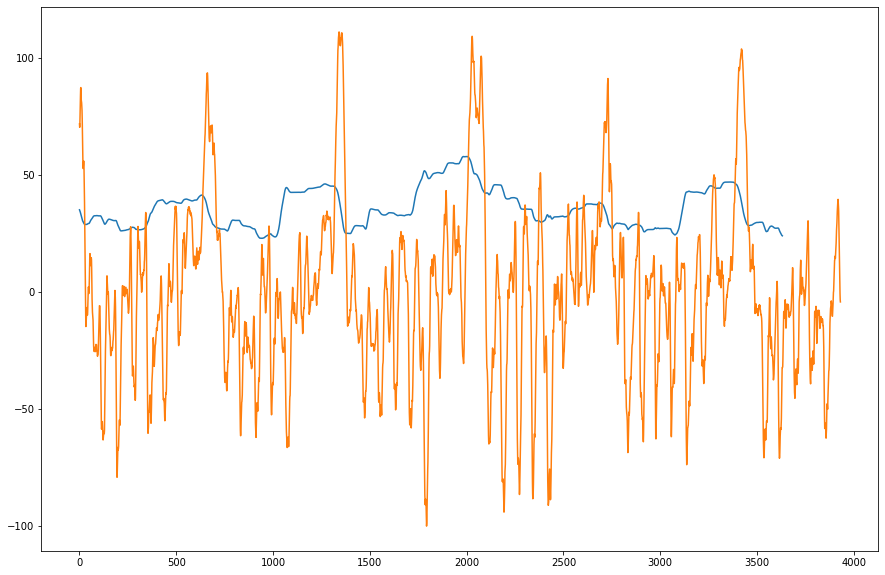

In [8]:
# Visualizing
i = 6003
fig, ax =  plt.subplots(1, 1, figsize=(15, 10))
plt.plot(s[i])
plt.plot(x_bcg_hi[i])

## Normalization

In [9]:
# Train
min_max_scaler = preprocessing.MinMaxScaler()
normalized_s = min_max_scaler.fit_transform(s)
# normalized_s = preprocessing.normalize(s)
# normalized_bcg_hi = min_max_scaler.fit_transform(x_bcg_hi)
normalized_bcg_hi = preprocessing.normalize(x_bcg_hi)

# Test
min_max_scaler = preprocessing.MinMaxScaler()
normalized_s_test = min_max_scaler.fit_transform(s_test)
# normalized_s_test = preprocessing.normalize(s_test)
normalized_bcg_hi_test = preprocessing.normalize(x_bcg_hi_test)

afib label is 0


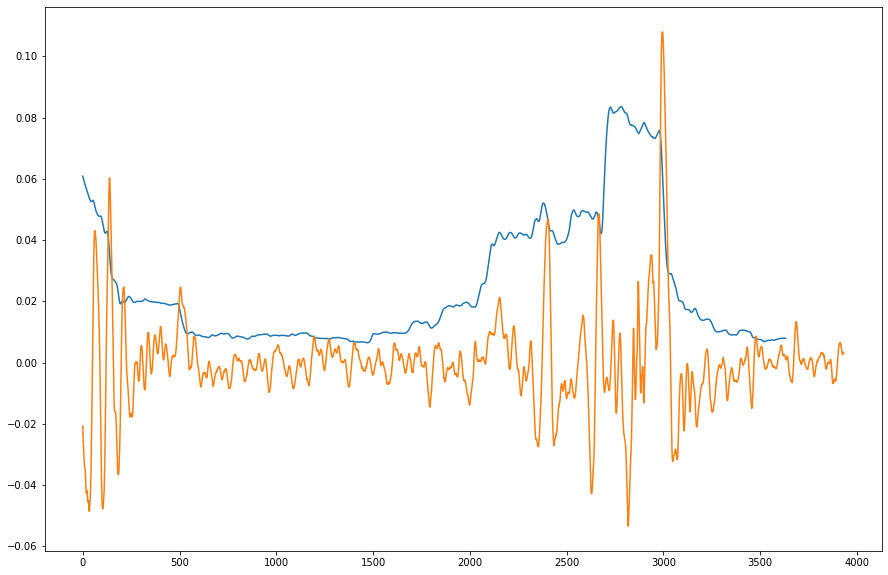

In [10]:
# Visualizing
i = 18130
fig, ax =  plt.subplots(1, 1, figsize=(15, 10))
plt.plot(normalized_s[i])
plt.plot(normalized_bcg_hi[i])
print('afib label is',afib[i])

## Thresholding

In [11]:
# Train
valid_segments = []
valid_segments_labels = []
sub = []

for i in range(len(normalized_bcg_hi)):
    if i%2000 == 0:
        print('[INFO]',i,'segments were thresholded')
    #end if

    upper_thres = len(normalized_s[i][normalized_s[i]>0.1]) #amount of filtered signal that has a amplitude of above 0.1 
    lower_thres = len(normalized_s[i][normalized_s[i]<0.01])  #amount of filtered signal that has a amplitude of below 0.01 

    if (upper_thres + lower_thres)/len(normalized_s[i]) < 0.30:
        valid_segments.append(normalized_bcg_hi[i])
        valid_segments_labels.append(afib[i])
        sub.append(x_sub[i])
    #end if
#end for
print('[INFO]',i,'segments were thresholded')
print('Total number of valid segments is',len(valid_segments))

# Test
valid_segments_test = []
valid_segments_labels_test = []
sub_test = []

for i in range(len(normalized_bcg_hi_test)):
    if i%2000 == 0:
        print('[INFO]',i,'segments were thresholded')
    #end if

    upper_thres = len(normalized_s_test[i][normalized_s_test[i]>0.1]) #amount of filtered signal that has a amplitude of above 0.1 
    lower_thres = len(normalized_s_test[i][normalized_s_test[i]<0.01]) #amount of filtered signal that has a amplitude of below 0.01
     
    if (upper_thres + lower_thres)/len(normalized_s_test[i]) < 0.30:
        valid_segments_test.append(normalized_bcg_hi_test[i])
        valid_segments_labels_test.append(afib_test[i])
        sub_test.append(x_sub_test[i])
    #end if
#end for
print('[INFO]',i,'segments were thresholded')
print('Total number of valid segments is',len(valid_segments_test))

[INFO] 0 segments were thresholded
[INFO] 2000 segments were thresholded
[INFO] 4000 segments were thresholded
[INFO] 6000 segments were thresholded
[INFO] 8000 segments were thresholded
[INFO] 10000 segments were thresholded
[INFO] 12000 segments were thresholded
[INFO] 14000 segments were thresholded
[INFO] 16000 segments were thresholded
[INFO] 18000 segments were thresholded
[INFO] 20000 segments were thresholded
[INFO] 22000 segments were thresholded
[INFO] 22909 segments were thresholded
Total number of valid segments is 16152
[INFO] 0 segments were thresholded
[INFO] 2000 segments were thresholded
[INFO] 4000 segments were thresholded
[INFO] 4828 segments were thresholded
Total number of valid segments is 3381


# AFib Detection using BCG

## Split Dataset into Train and Test sets

### Selected filtered segments

In [12]:
# split dataset into train, validation and test sets

HIGH_X_train, HIGH_X_val, HIGH_Y_train, HIGH_Y_val = train_test_split(valid_segments, valid_segments_labels, test_size=0.1, random_state=7)

HIGH_X_train = np.array(HIGH_X_train)
HIGH_Y_train = np.array(HIGH_Y_train)
HIGH_X_train = np.expand_dims(HIGH_X_train, 2)

HIGH_X_val = np.array(HIGH_X_val)
HIGH_Y_val = np.array(HIGH_Y_val)
HIGH_X_val = np.expand_dims(HIGH_X_val, 2)

HIGH_X_test  = np.array(valid_segments_test)
HIGH_Y_test  = np.array(valid_segments_labels_test)
HIGH_X_test = np.expand_dims(HIGH_X_test, 2)

print('BCG-HIGH-filtered: train',HIGH_X_train.shape, ' val', HIGH_X_val.shape, ' test', HIGH_X_test.shape)

print('Train Set:')
print('normal ', np.count_nonzero(HIGH_Y_train == 0))
print('AFib ', np.count_nonzero(HIGH_Y_train == 1))

print('Validation Set:')
print('normal ', np.count_nonzero(HIGH_Y_val == 0))
print('AFib ', np.count_nonzero(HIGH_Y_val == 1))

print('Test Set:')
print('normal ', np.count_nonzero(HIGH_Y_test == 0))
print('AFib ', np.count_nonzero(HIGH_Y_test == 1))

BCG-HIGH-filtered: train (14536, 3932, 1)  val (1616, 3932, 1)  test (3381, 3932, 1)
Train Set:
normal  6817
AFib  7719
Validation Set:
normal  774
AFib  842
Test Set:
normal  1509
AFib  1872


## Neural Network

In [14]:
model = create_model(input_shape=HIGH_X_train.shape[-2:], cnn_filters_number=32, activation_function=tf.keras.layers.ReLU(), dropout_ratio=0, summary_verbose=True, model_plot=True)

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BCG (InputLayer)            [(None, 3932, 1)]         0         
                                                                 
 CNN1 (Conv1D)               (None, 767, 32)           3232      
                                                                 
 batch_normalization_9 (Batc  (None, 767, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_11 (Activation)  (None, 767, 32)           0         
                                                                 
 CNN2 (Conv1D)               (None, 384, 64)           6208      
                                                                 
 batch_normalization_10 (Bat  (None, 384, 64)          256       
 chNormalization)                                       

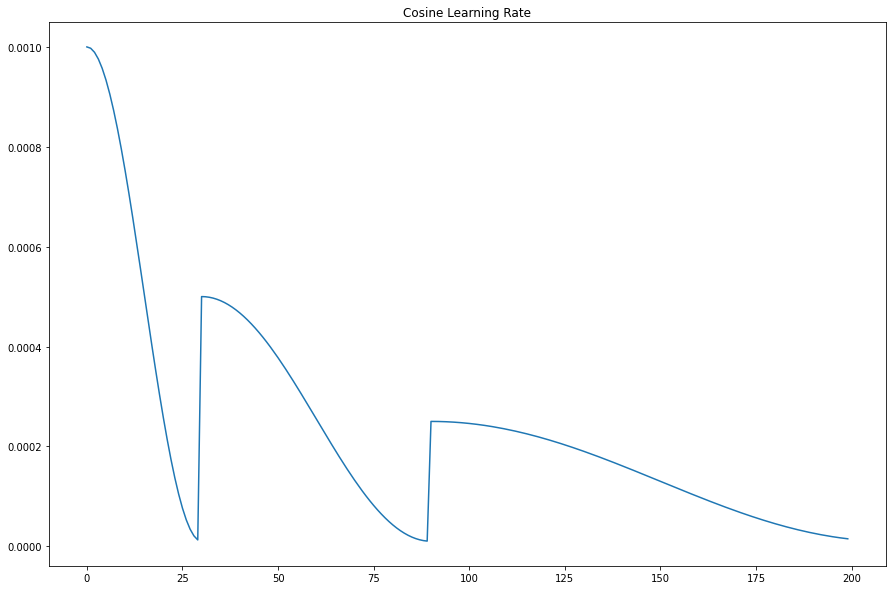

In [19]:
# AFIB Model Parameters

scheduler = cosine_learning_rate_scheduler(num_epoch=200, restart_number=30, start_lr=1e-3, lr_min=1e-5, cycle_limit=4, cycle_mul=2, cycle_decay=0.5, plot_status=True)
def keras_scheduler(epoch):
    return scheduler.get_epoch_values(epoch)[0]
#end keras_scheduler

# f1 = tfa.metrics.F1Score(num_classes=2,average='macro')
accu = tf.keras.metrics.BinaryAccuracy(name='accuracy')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')
auc = tf.keras.metrics.AUC(name='auc')

starter_learning_rate = 0.001

model.compile(
    # loss = tf.keras.losses.BinaryCrossentropy(), 
    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, name='binary_focal_crossentropy',),

    # optimizer=tf.keras.optimizers.RMSprop(learning_rate=starter_learning_rate),
    optimizer=tf.keras.optimizers.Adam(),

    metrics=[precision, recall, accu,  auc, my_metric], #my_metric_bcg_model
)


checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath='model_{epoch:02d}_val_accuracy{val_accuracy:.4f}_val_precision{val_precision:.4f}_val_recall{val_recall:.4f}.h5', 
            monitor='val_my_metric', verbose=1, 
            save_best_only=True, mode='max')

checkpoint2 = tf.keras.callbacks.LearningRateScheduler(keras_scheduler)

callback = [checkpoint1,
            checkpoint2
            ]

In [ ]:
# Training Model
h = model.fit(x={"BCG": HIGH_X_train}, 
              y=HIGH_Y_train, 
              validation_data=( {"BCG": HIGH_X_val}, HIGH_Y_val ), 
              batch_size=256, #8192, 
              epochs=200, 
              callbacks=callback
              )

## Plot


In [ ]:
# Visualization
history = h.history
Train_acc = history["accuracy"]
Val_acc = history["val_accuracy"]

Train_loss = history["loss"]
Val_loss = history["val_loss"]

Train_recall = history["recall"]
Val_recall = history["val_recall"]


fig1 = plt.figure(figsize = [12,8])
plt.plot(Train_acc, label='Train accuracy')
plt.plot(Val_acc, label='Val accuracy')

plt.plot(Train_recall, label='Train recall')
plt.plot(Val_recall, label='Val recall')

plt.plot(Train_loss, label='Train loss')
plt.plot(Val_loss, label='Val loss')

plt.xlabel("Epoch")
plt.ylabel("Recall/Loss")
plt.legend()
plt.title('Trained Model Recall/Loss')
plt.show()

# Testing

In [21]:
# Loading AFib Trained Models
files = ['model_28_0.7968_0.7293_0.9123.h5',
         'model_100_0.8179_0.7824_0.8560.h5',
         'model_68_0.8198_0.7850_0.8566.h5',
         'model_60_val_accuracy0.6581_val_precision0.6255_val_recall0.9033.h5',
         'model_59_val_accuracy0.6888_val_precision0.6613_val_recall0.8601.h5',
         'model_131_val_accuracy0.6894_val_precision0.6619_val_recall0.8601.h5',
         ]
model = tf.keras.models.load_model(
    filepath=files[0]
    , custom_objects={'my_metric': my_metric}
)

# Evaluating the model on the test data
print("Evaluate on test data")
results = model.evaluate(x={"BCG": HIGH_X_test}, y=HIGH_Y_test, batch_size=512)
print("test loss, test precision, test recall, test accuracy, test auc, test my_metric:")
print(results)

Evaluate on test data
7/7 [==============================] - 16s 2s/step - loss: 0.5303 - precision: 0.5847 - recall: 0.8851 - accuracy: 0.5883 - auc: 0.6408 - my_metric: 0.4763
test loss, test precision, test recall, test accuracy, test auc, test my_metric:
[0.5303244590759277, 0.5846859812736511, 0.8851495981216431, 0.5882874727249146, 0.6407555341720581, 0.47634413838386536]
